In [1]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

### Read in dataset

In [2]:
data_df = pd.read_csv('/dfs/user/yhr/research_assistant/datasets/ground_truth_IFNG.csv')
topmovers = np.load('/dfs/user/yhr/research_assistant/datasets/topmovers_IFNG.npy')
all_genes = data_df['Gene'].values

### Random baseline

In [3]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def return_hits(list_):
    return list(set(list_).intersection(set(topmovers)))

def get_all_sampled_genes(exp_path, num_rounds = 100):
    all_sampled_genes = []
    for i in range(1,num_rounds):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr):
    return list(set(arr).intersection(set(topmovers)))

### genedisco fixing dataloader

In [14]:
num_steps = 20
sample_size = 256
results = pd.read_pickle('/dfs/user/yhr/genedisco/results_coreset/results.pickle')[:num_steps]
results_old = pd.read_pickle('/dfs/user/yhr/genedisco/results_coreset_old/results.pickle')[:num_steps]
##random_results = pd.read_pickle('/dfs/user/yhr/genedisco-starter/genedisco_output_ifng_random_1/results.pickle')

In [15]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

for rep in range(1, 3+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
        
# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

In [16]:
hits_ml_model = [x['HitRatio'] for x in results]
hits_old_ml_model = [x['HitRatio'] for x in results_old]

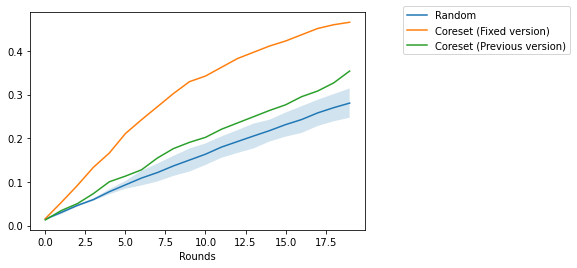

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# add the coreset results to the plot
plt.plot(np.arange(num_steps), hits_ml_model, label='Coreset (Fixed version)')

# add the wrong model results to the plot
plt.plot(np.arange(num_steps), hits_old_ml_model, label='Coreset (Previous version)')

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()

### Equal sampling: Claude

In [4]:
import glob

exp_paths = {
 '1':'/dfs/user/yhr/research_assistant/logs_IFNG/exp1/sampled_genes_',
 '2':'/dfs/user/yhr/research_assistant/logs_IFNG/exp2/sampled_genes_',
 '3':'/dfs/user/yhr/research_assistant/logs_IFNG/exp3/sampled_genes_',
}

In [15]:
sampled_genes = {}
sample_sizes = {}
hits = {}
hit_rates = {}
num_rounds = 24
filter_zero_sets = True

for rep in range(1, len(exp_paths)+1):
    rep = str(rep)
    sampled_genes[rep] = get_all_sampled_genes(exp_paths[rep], num_rounds=num_rounds)
    sample_sizes[rep] = get_successful_sample_sizes(sampled_genes[rep])
    if filter_zero_sets:
         sampled_genes[rep] = [sampled_genes[rep][itr] for itr in np.where(np.array(sample_sizes[rep])!= 0)[0]]
    
    hits[rep] = []
    hit_rates[rep] = []
    hits[rep] = [return_hits(x) for x in sampled_genes[rep]]
    hit_rates[rep] = [len(x)/len(topmovers) for x in hits[rep]]

<BarContainer object of 23 artists>

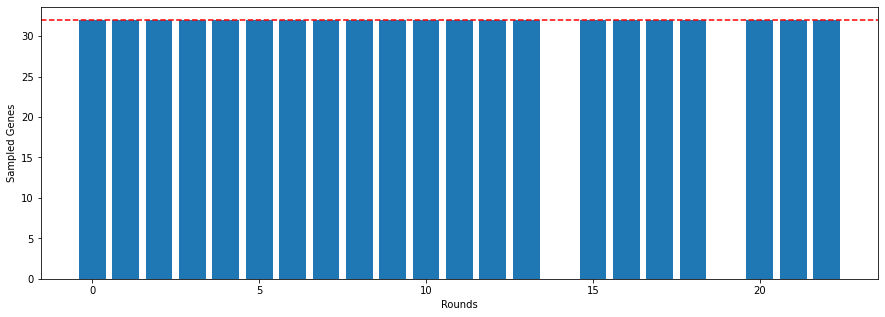

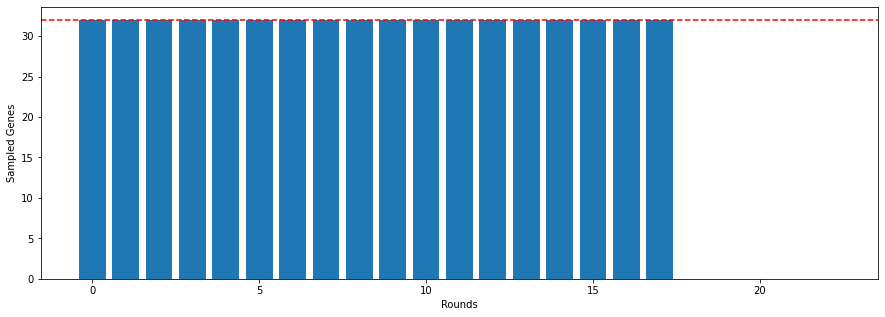

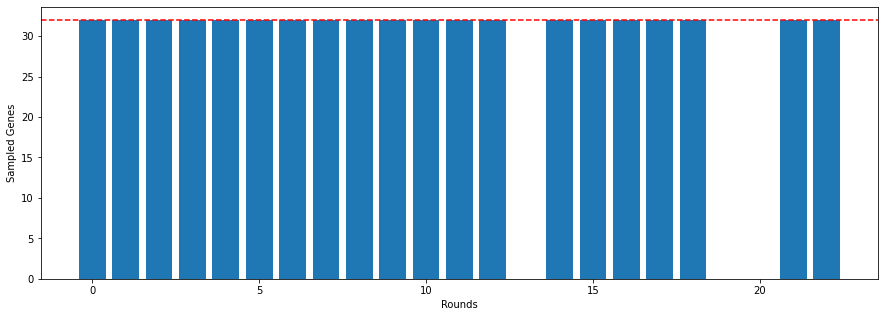

In [16]:
## GPT has trouble counting

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['1'])

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['2'])

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['3'])

In [17]:
num_steps = np.min([len(x) for x in sampled_genes.values()])
num_reps = 3
sample_size=32

In [18]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

for rep in range(1, len(exp_paths)+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
        
# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

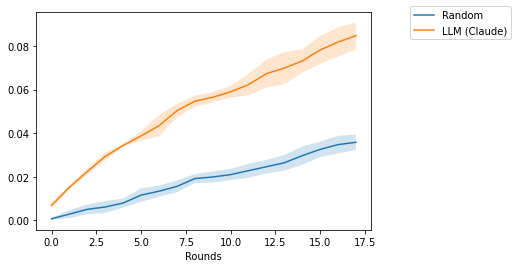

In [19]:
import matplotlib.pyplot as plt
import numpy as np


ai_ra_mean_claude = np.mean(np.array([x[:num_steps] for x in hit_rates.values()]),0)
ai_ra_std_claude = np.std(np.array([x[:num_steps] for x in hit_rates.values()]),0)


# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# add the GPT data to the plot
plt.plot(np.arange(num_steps), ai_ra_mean_claude, label='LLM (Claude)')
plt.fill_between(np.arange(num_steps), ai_ra_mean_claude - ai_ra_std_claude, 
                             ai_ra_mean_claude + ai_ra_std_claude, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()

### Equal sampling: GPT4

In [38]:
import glob

exp_paths = {
 '1':'/dfs/user/yhr/research_assistant/logs_Belk22/exp_gpt4_fix_1/sampled_genes_',
 #'2':'/dfs/user/yhr/research_assistant/logs_Belk22/exp_gpt4_2/sampled_genes_'
}

In [39]:
sampled_genes = {}
sample_sizes = {}
hits = {}
hit_rates = {}
num_rounds = 24
filter_zero_sets = True

for rep in range(1, len(exp_paths)+1):
    rep = str(rep)
    sampled_genes[rep] = get_all_sampled_genes(exp_paths[rep], num_rounds=num_rounds)
    sample_sizes[rep] = get_successful_sample_sizes(sampled_genes[rep])
    if filter_zero_sets:
         sampled_genes[rep] = [sampled_genes[rep][itr] for itr in np.where(np.array(sample_sizes[rep])!= 0)[0]]
    
    hits[rep] = []
    hit_rates[rep] = []
    hits[rep] = [return_hits(x) for x in sampled_genes[rep]]
    hit_rates[rep] = [len(x)/len(topmovers) for x in hits[rep]]

"\nplt.figure(figsize=[15,5])\nplt.ylabel('Sampled Genes')\nplt.xlabel('Rounds')\nplt.axhline(y=32, color='r', linestyle='--')\nplt.bar(range(len(sample_sizes['1'])), sample_sizes['2'])\n\nplt.figure(figsize=[15,5])\nplt.ylabel('Sampled Genes')\nplt.xlabel('Rounds')\nplt.axhline(y=32, color='r', linestyle='--')\nplt.bar(range(len(sample_sizes['1'])), sample_sizes['3'])\n"

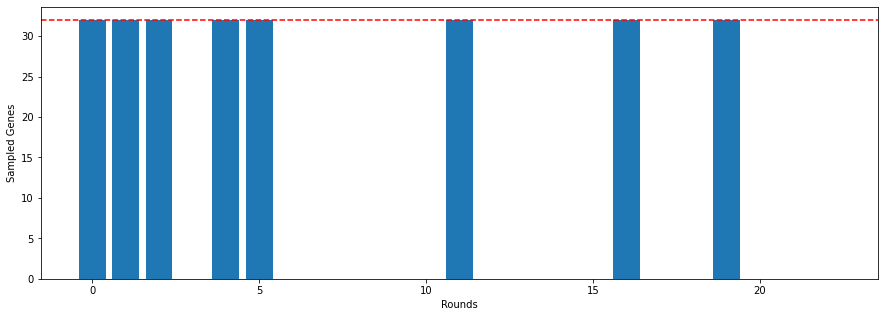

In [40]:
## GPT has trouble counting

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['1'])

"""
plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['2'])

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['3'])
"""

In [41]:
num_steps = np.min([len(x) for x in sampled_genes.values()])
num_reps = 3
sample_size=32

In [42]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

for rep in range(1, len(exp_paths)+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)


ai_ra_mean_gpt4 = np.mean(np.array([x[:num_steps] for x in hit_rates.values()]),0)
ai_ra_std_gpt4 = np.std(np.array([x[:num_steps] for x in hit_rates.values()]),0)


# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# add the GPT data to the plot
plt.plot(np.arange(num_steps), ai_ra_mean_gpt4, label='LLM (Claude)')
plt.fill_between(np.arange(num_steps), ai_ra_mean_gpt4 - ai_ra_std_gpt4, 
                             ai_ra_mean_gpt4 + ai_ra_std_gpt4, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()

### Equal sampling: GPT3.5

In [44]:
import glob

exp_paths = {
 '1':'/dfs/user/yhr/research_assistant/logs_Belk22/gpt3.5_exp1/sampled_genes_',
 '2':'/dfs/user/yhr/research_assistant/logs_Belk22/gpt3.5_exp2/sampled_genes_',
 '3':'/dfs/user/yhr/research_assistant/logs_Belk22/gpt3.5_exp3/sampled_genes_',
}

In [45]:
sampled_genes = {}
sample_sizes = {}
hits = {}
hit_rates = {}
num_rounds = 25
filter_zero_sets = True

for rep in range(1, len(exp_paths)+1):
    rep = str(rep)
    sampled_genes[rep] = get_all_sampled_genes(exp_paths[rep], num_rounds=num_rounds)
    sample_sizes[rep] = get_successful_sample_sizes(sampled_genes[rep])
    if filter_zero_sets:
         sampled_genes[rep] = [sampled_genes[rep][itr] for itr in np.where(np.array(sample_sizes[rep])!= 0)[0]]
    
    hits[rep] = []
    hit_rates[rep] = []
    hits[rep] = [return_hits(x) for x in sampled_genes[rep]]
    hit_rates[rep] = [len(x)/len(topmovers) for x in hits[rep]]

In [ ]:
## GPT has trouble counting

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['1'])

"""
plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['2'])

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['3'])
"""

In [47]:
num_steps = np.min([len(x) for x in sampled_genes.values()]) -1
num_reps = 3
sample_size=32

In [ ]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

for rep in range(1, len(exp_paths)+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)


ai_ra_mean_gpt35 = np.mean(np.array([x[:num_steps] for x in hit_rates.values()]),0)
ai_ra_std_gpt35 = np.std(np.array([x[:num_steps] for x in hit_rates.values()]),0)


# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# add the GPT data to the plot
plt.plot(np.arange(num_steps), ai_ra_mean_gpt35, label='LLM (GPT3.5)')
plt.fill_between(np.arange(num_steps), ai_ra_mean_gpt35 - ai_ra_std_gpt35, 
                             ai_ra_mean_gpt35 + ai_ra_std_gpt35, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()

### ML Model

In [49]:
REPS = ['1', '2']
ACQUISITION_FUNCTIONS = [
        "random", "topuncertain", "softuncertain", "marginsample", "coreset", "badge",
        "kmeans_embedding", "kmeans_data", "adversarialBIM", "custom"
    ]
SCREEN_NAMES = ['Adenosine', 'TGFb', 'Cyclosporine', 'Tacrolimus']

In [50]:
def read_ml_rounds(out_name, num_steps):
    path = '/dfs/user/yhr/genedisco/'+out_name +'/'
    all_pred_genes = []
    for i in range(num_steps):
        try:
            all_pred_genes.append(pd.read_pickle(path+'cycle_{}/selected_indices.pickle'.format(i)))
        except:
            print('No sampling round {}'.format(i))
    return all_pred_genes

In [51]:
model_name = 'coreset'
#model_name = 'kmeansdata'

#out_name = 'results_'+model_name+'_fix'
out_name = 'results_'+model_name

ml_rounds = {}
ml_hits = {}
ml_hit_rates = {}
num_steps = 18

for rep in range(1, 1+1):
    rep=str(rep)
    ml_rounds[rep] = read_ml_rounds(out_name, num_steps)
    
    ml_hits[rep] = []
    ml_hit_rates[rep] = []
    for step in range(num_steps):
        ml_hits[rep].append(return_hits(ml_rounds[rep][step]))
        ml_hit_rates[rep].append(len(ml_hits[rep][-1])/len(topmovers))

In [52]:
# calculate the mean and standard deviation of the random data
ml_mean = np.mean(np.array([x for x in ml_hit_rates.values()]),0)
ml_std = np.std(np.array([x for x in ml_hit_rates.values()]),0)

In [53]:
num_reps = 2
sample_size=256

In [54]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

for rep in range(1, 3+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))

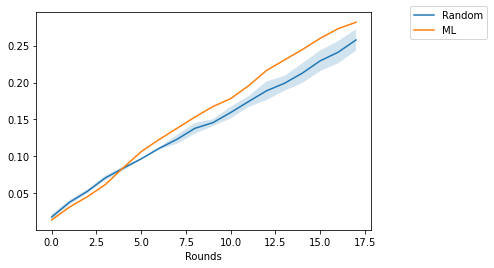

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# add the GPT data to the plot
plt.plot(np.arange(num_steps), ml_mean, label='ML')
plt.fill_between(np.arange(num_steps), ml_mean - ml_std, 
                             ml_mean + ml_std, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()

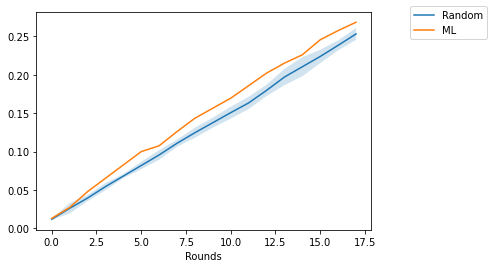

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# add the GPT data to the plot
plt.plot(np.arange(num_steps), ml_mean, label='ML')
plt.fill_between(np.arange(num_steps), ml_mean - ml_std, 
                             ml_mean + ml_std, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()

In [45]:
## Validate that h5s are generated correctly

import h5py

# Open the h5 file in read mode
with h5py.File('/dfs/user/yhr/genedisco/genedisco/genedisco_cache/schmidt_2021_ifng.h5', 'r') as f:
    # List the keys at the root level of the file
    #print(list(f.items()))
    
    
    # Get a dataset from the file
    covariates = f['covariates']
    covariates_values = covariates[()]
    #print(covariates_values)
    
    # Get a dataset from the file
    rownames = f['rownames']
    rownames_values = rownames[()]
    #print(rownames_values)
    
    # Get a dataset from the file
    colnames = f['colnames']
    colnames_values = colnames[()]
    #print(colnames_values)
    
data_df = pd.DataFrame(index = np.array(rownames_values).astype('str'))
data_df[colnames_values[0].decode()] = np.array(covariates_values).flatten()

In [48]:
data_df.sort_values('log-fold-change')

,log-fold-change
ZAP70,-3.91885
VAV1,-3.84365
CD3G,-3.62610
CD3D,-3.31385
LCP2,-2.92870
...,...
CBLB,1.35810
CD5,1.48280
RNF40,1.53100
NFKB2,1.58430


### Combined plot

In [70]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

num_steps = max(len(ai_ra_mean_gpt35),
len(ai_ra_mean_gpt4),
len(ai_ra_mean_claude),
len(ml_mean))

for rep in range(1, len(exp_paths)+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
        
# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

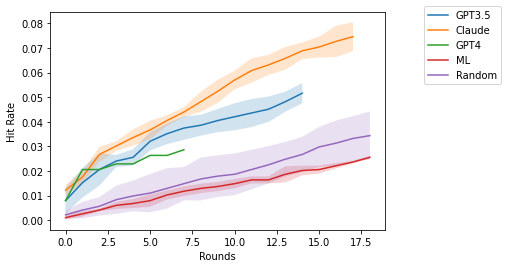

In [71]:
# add the GPT data to the plot

num_steps = len(ai_ra_mean_gpt35)
plt.plot(np.arange(num_steps), ai_ra_mean_gpt35, label='GPT3.5')
plt.fill_between(np.arange(num_steps), ai_ra_mean_gpt35 - ai_ra_std_gpt35, 
                             ai_ra_mean_gpt35 + ai_ra_std_gpt35, alpha=0.2)


num_steps = len(ai_ra_mean_claude)
plt.plot(np.arange(num_steps), ai_ra_mean_claude, label='Claude')
plt.fill_between(np.arange(num_steps), ai_ra_mean_claude - ai_ra_std_claude, 
                             ai_ra_mean_claude + ai_ra_std_claude, alpha=0.2)


num_steps = len(ai_ra_mean_gpt4)
plt.plot(np.arange(num_steps), ai_ra_mean_gpt4, label='GPT4')
plt.fill_between(np.arange(num_steps), ai_ra_mean_gpt4 - ai_ra_std_gpt4, 
                             ai_ra_mean_gpt4 + ai_ra_std_gpt4, alpha=0.2)


num_steps = len(ml_mean)
plt.plot(np.arange(num_steps), ml_mean, label='ML')
plt.fill_between(np.arange(num_steps), ml_mean - ml_std, 
                             ml_mean + ml_std, alpha=0.2)



num_steps = len(random_mean)
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')
plt.ylabel('Hit Rate')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()